<a href="https://colab.research.google.com/github/Amplil/genetic_programming/blob/master/genetic_programming_official_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --target "/content/drive/MyDrive/Colab Notebooks/packages" deap

In [ ]:
# !pip install deap

In [2]:
# !apt-get install -y graphviz-dev

In [ ]:
#!pip install --target "/content/drive/MyDrive/Colab Notebooks/packages" pygraphviz

^C


In [1]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/packages")

In [2]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt
#import pygraphviz as pgv
import networkx as nx

# [公式ドキュメントGenetic Programming](https://deap.readthedocs.io/en/master/tutorials/advanced/gp.html)のテスト

In [3]:
pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(max, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addTerminal(3)

In [4]:
pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

In [5]:
pset.addPrimitive(operator.neg, 1)

In [6]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)

In [18]:
tree

In [7]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.renameArguments(ARG0='x')

creator.create("Individual", gp.PrimitiveTree)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)

In [12]:
"""
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")
"""

In [12]:
labels

{0: 'sub', 1: 'sub', 2: 'x', 3: 'x', 4: 'sub', 5: 'x', 6: 'x'}

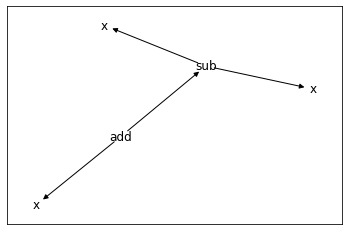

In [20]:
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos=nx.spring_layout(g)
nx.draw_networkx_edges(g,pos)
nx.draw_networkx_labels(g,pos,labels)
plt.show()

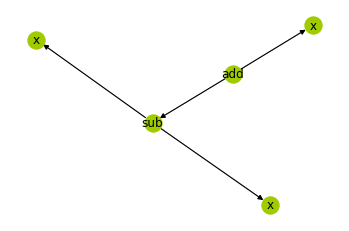

In [21]:
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos=nx.spring_layout(g)
nx.draw_networkx_edges(g,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(g,pos,labels)
nx.draw(g,pos,node_color='#A0CB00')
plt.show()

# Even-Parity Problem

In [22]:
# Initialize Parity problem input and output matrices
PARITY_FANIN_M = 6
PARITY_SIZE_M = 2**PARITY_FANIN_M

In [23]:
inputs = [None] * PARITY_SIZE_M
outputs = [None] * PARITY_SIZE_M

In [24]:
for i in range(PARITY_SIZE_M):
    inputs[i] = [None] * PARITY_FANIN_M
    value = i
    dividor = PARITY_SIZE_M
    parity = 1
    for j in range(PARITY_FANIN_M):
        dividor /= 2
        if value >= dividor:
            inputs[i][j] = 1
            parity = int(not parity)
            value -= dividor
        else:
            inputs[i][j] = 0
    outputs[i] = parity

In [25]:
pset = gp.PrimitiveSet("MAIN", PARITY_FANIN_M, "IN")
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

In [26]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

/content/drive/MyDrive/Colab Notebooks/packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [27]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
expr=toolbox.individual
toolbox.register("population", tools.initRepeat, list, expr)
toolbox.register("compile", gp.compile, pset=pset)

In [28]:
def evalParity(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*in_) == out for in_, out in zip(inputs, outputs)),

In [29]:
toolbox.register("evaluate", evalParity)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [30]:
random.seed(21)
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 40, stats, halloffame=hof)

gen	nevals	avg    	std    	min	max
0  	300   	31.9867	1.23551	24 	48 
1  	185   	31.9933	0.565646	24 	36 
2  	175   	32.0633	0.415518	30 	36 
3  	184   	32.1567	0.65227 	30 	37 
4  	182   	32.25  	0.852936	30 	37 
5  	194   	32.4667	1.20922 	28 	37 
6  	183   	32.91  	1.62129 	28 	38 
7  	199   	33.3   	1.84842 	28 	40 
8  	175   	33.7433	2.03735 	28 	40 
9  	183   	34.2033	2.17148 	28 	40 
10 	182   	34.3933	2.27126 	28 	40 
11 	192   	34.6667	2.34852 	22 	40 
12 	173   	34.9267	2.4889  	28 	40 
13 	165   	35.1533	2.70736 	24 	42 
14 	164   	35.51  	2.72578 	26 	42 
15 	174   	35.7467	3.00153 	24 	44 
16 	166   	36.06  	3.30501 	28 	44 
17 	179   	36.3633	3.84075 	20 	44 
18 	183   	37.01  	3.96357 	20 	44 
19 	181   	37.87  	3.79558 	26 	44 
20 	183   	38.1267	4.41633 	24 	44 
21 	185   	38.57  	4.43679 	24 	46 
22 	201   	38.5933	5.01942 	18 	46 
23 	165   	39.67  	4.82159 	21 	48 
24 	178   	40.65  	4.8943  	20 	48 
25 	177   	41.0133	5.06029 	25 	48 
26 	158   	41.51  	5.65537 	18

([[<deap.gp.Primitive at 0x7fde1ba78fb0>,
 [{'avg': 31.986666666666668,
   'gen': 0,
   'max': 48.0,
   'min': 24.0,
   'nevals': 300,
   'std': 1.235511589945189},
  {'avg': 31.993333333333332,
   'gen': 1,
   'max': 36.0,
   'min': 24.0,
   'nevals': 185,
   'std': 0.5656461398750596},
  {'avg': 32.06333333333333,
   'gen': 2,
   'max': 36.0,
   'min': 30.0,
   'nevals': 175,
   'std': 0.41551841782952964},
  {'avg': 32.156666666666666,
   'gen': 3,
   'max': 37.0,
   'min': 30.0,
   'nevals': 184,
   'std': 0.6522695421032286},
  {'avg': 32.25,
   'gen': 4,
   'max': 37.0,
   'min': 30.0,
   'nevals': 182,
   'std': 0.852936105461599},
  {'avg': 32.46666666666667,
   'gen': 5,
   'max': 37.0,
   'min': 28.0,
   'nevals': 194,
   'std': 1.2092238098144703},
  {'avg': 32.91,
   'gen': 6,
   'max': 38.0,
   'min': 28.0,
   'nevals': 183,
   'std': 1.6212854981978548},
  {'avg': 33.3,
   'gen': 7,
   'max': 40.0,
   'min': 28.0,
   'nevals': 199,
   'std': 1.848422751068236},
  {'avg': 

In [31]:
hof

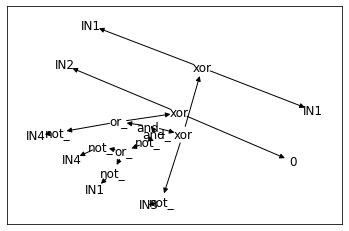

In [33]:
expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos=nx.spring_layout(g)
nx.draw_networkx_edges(g,pos)
nx.draw_networkx_labels(g,pos,labels)
plt.show()

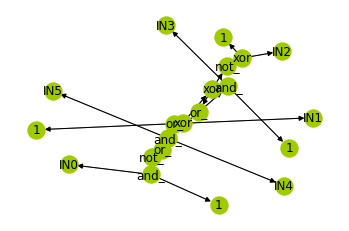

In [34]:
expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos=nx.spring_layout(g)
nx.draw_networkx_edges(g,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(g,pos,labels)
nx.draw(g,pos,node_color='#A0CB00')
plt.show()